Đã phát hiện 20 đồng xu:
Đồng xu 1: Tâm(1162, 694), Bán kính: 119, Diện tích: 44488, Độ tròn: 0.850, Tỷ lệ diện tích: 0.999
Đồng xu 2: Tâm(1114, 905), Bán kính: 119, Diện tích: 44488, Độ tròn: 0.850, Tỷ lệ diện tích: 0.983
Đồng xu 3: Tâm(1382, 674), Bán kính: 119, Diện tích: 44488, Độ tròn: 0.850, Tỷ lệ diện tích: 0.952
Đồng xu 4: Tâm(590, 1022), Bán kính: 119, Diện tích: 44488, Độ tròn: 0.850, Tỷ lệ diện tích: 0.974
Đồng xu 5: Tâm(1066, 433), Bán kính: 119, Diện tích: 44488, Độ tròn: 0.850, Tỷ lệ diện tích: 0.970
Đồng xu 6: Tâm(762, 666), Bán kính: 117, Diện tích: 43005, Độ tròn: 0.850, Tỷ lệ diện tích: 0.999
Đồng xu 7: Tâm(1286, 422), Bán kính: 117, Diện tích: 43005, Độ tròn: 0.850, Tỷ lệ diện tích: 0.999
Đồng xu 8: Tâm(914, 553), Bán kính: 117, Diện tích: 43005, Độ tròn: 0.850, Tỷ lệ diện tích: 0.958
Đồng xu 9: Tâm(726, 378), Bán kính: 117, Diện tích: 43005, Độ tròn: 0.850, Tỷ lệ diện tích: 0.971
Đồng xu 10: Tâm(338, 694), Bán kính: 117, Diện tích: 43005, Độ tròn: 0.850, Tỷ lệ diện 

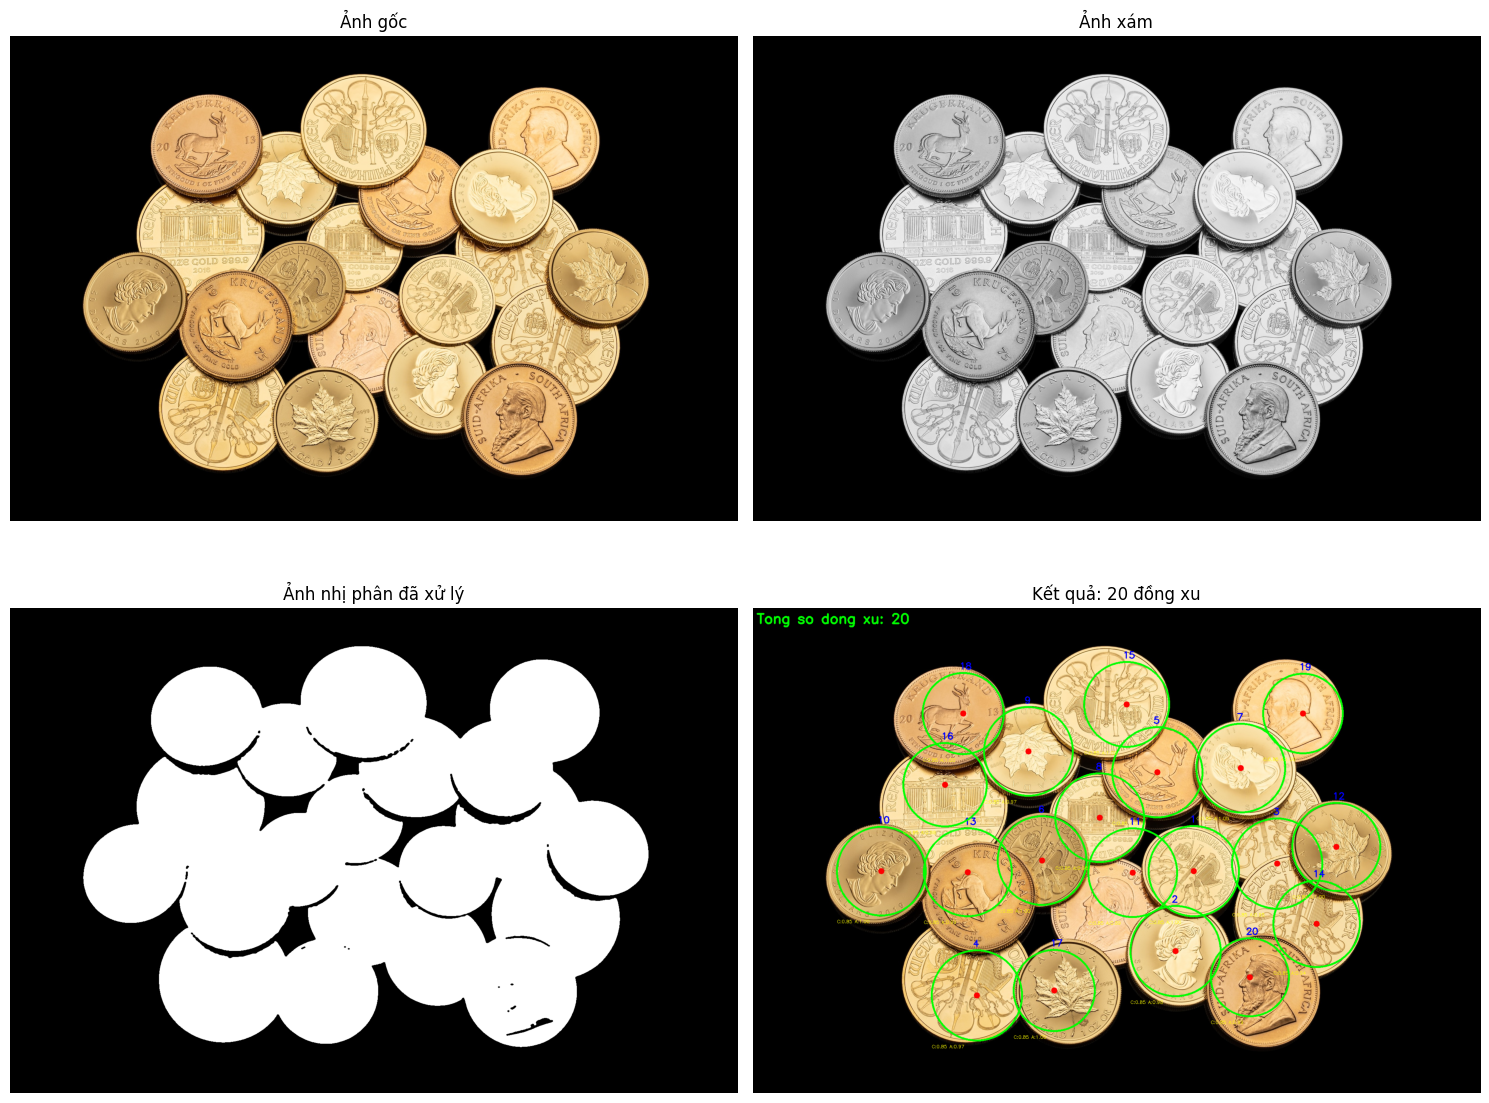

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class ImprovedCoinCounter:
    def __init__(self):
        self.min_coin_area = 800
        self.max_coin_area = 25000

    def remove_small_objects(self, binary_image, min_size=200):
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
        mask = np.zeros_like(binary_image)
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            if area >= min_size:
                mask[labels == i] = 255
        return mask

    def find_local_maxima(self, distance_transform, min_distance=12, threshold=None):
        if threshold is None:
            threshold = 0.3 * distance_transform.max()
        kernel_size = min_distance
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        dilated = cv2.dilate(distance_transform, kernel)
        maxima_mask = (distance_transform == dilated) & (distance_transform >= threshold)
        maxima_coords = np.where(maxima_mask)
        local_maxima = list(zip(maxima_coords[0], maxima_coords[1]))
        return local_maxima

    def watershed_segmentation(self, binary_image, distance_transform):
        local_maxima = self.find_local_maxima(distance_transform, min_distance=25)
        markers = np.zeros(distance_transform.shape, dtype=np.int32)
        for i, (y, x) in enumerate(local_maxima):
            markers[y, x] = i + 1
        distance_3d = cv2.cvtColor((distance_transform * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        cv2.watershed(distance_3d, markers)
        return markers, local_maxima

    def preprocess_image(self, image):
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
        denoised = cv2.medianBlur(gray, 5)
        blurred = cv2.GaussianBlur(denoised, (7, 7), 1.5)
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if np.mean(binary) > 127:
            binary = cv2.bitwise_not(binary)
        binary = self.remove_small_objects(binary, min_size=200)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        return gray, binary

    def validate_coin_shape(self, contour):
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        if area < self.min_coin_area or area > self.max_coin_area:
            return False, 0
        if perimeter == 0:
            return False, 0
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity < 0.6:
            return False, circularity
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else 10
        if aspect_ratio > 1.5:
            return False, circularity
        return True, circularity

    def detect_coins_contour_analysis(self, binary_image):
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        valid_coins = []
        for contour in contours:
            is_valid, circularity = self.validate_coin_shape(contour)
            if is_valid:
                (x, y), radius = cv2.minEnclosingCircle(contour)
                if self.min_coin_radius <= radius <= self.max_coin_radius:
                    contour_area = cv2.contourArea(contour)
                    circle_area = np.pi * radius * radius
                    area_ratio = contour_area / circle_area
                    if area_ratio > 0.7 and circularity > 0.6:
                        valid_coins.append({
                            'center': (int(x), int(y)),
                            'radius': int(radius),
                            'contour': contour,
                            'circularity': circularity,
                            'area_ratio': area_ratio,
                            'area': contour_area
                        })
        return valid_coins

    def detect_coins_watershed(self, binary_image):
        dist_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 5)
        markers, local_maxima = self.watershed_segmentation(binary_image, dist_transform)
        coins = []
        for label in np.unique(markers):
            if label <= 0:
                continue
            mask = (markers == label).astype(np.uint8) * 255
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                contour = max(contours, key=cv2.contourArea)
                is_valid, circularity = self.validate_coin_shape(contour)
                if is_valid:
                    (x, y), radius = cv2.minEnclosingCircle(contour)
                    if self.min_coin_radius <= radius <= self.max_coin_radius:
                        contour_area = cv2.contourArea(contour)
                        circle_area = np.pi * radius * radius
                        area_ratio = contour_area / circle_area
                        if area_ratio > 0.6 and circularity > 0.55:
                            coins.append({
                                'center': (int(x), int(y)),
                                'radius': int(radius),
                                'contour': contour,
                                'circularity': circularity,
                                'area_ratio': area_ratio,
                                'area': contour_area
                            })
        return coins

    def detect_coins_hough_improved(self, gray_image, binary_image):
        edges = cv2.Canny(gray_image, 50, 150, apertureSize=3)
        edges = cv2.bitwise_and(edges, binary_image)
        circles = cv2.HoughCircles(
            edges,
            cv2.HOUGH_GRADIENT,
            dp=1.6,
            minDist=160,
            param1=50,
            param2=70,
            minRadius=90,
            maxRadius=120
        )
        validated_circles = []
        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")
            for (x, y, r) in circles:
                mask = np.zeros(gray_image.shape, dtype=np.uint8)
                cv2.circle(mask, (x, y), r, 255, -1)
                overlap = cv2.bitwise_and(binary_image, mask)
                overlap_area = np.sum(overlap > 0)
                circle_area = np.pi * r * r
                overlap_ratio = overlap_area / circle_area
                if overlap_ratio > 0.6:
                    validated_circles.append({
                        'center': (x, y),
                        'radius': r,
                        'area': circle_area,
                        'circularity': 0.85,
                        'area_ratio': overlap_ratio
                    })
        return validated_circles

    def remove_overlapping_detections(self, coins_list, overlap_threshold=0.6):
        if len(coins_list) <= 1:
            return coins_list
        coins_list.sort(key=lambda x: x['area'], reverse=True)
        final_coins = []
        for coin1 in coins_list:
            is_duplicate = False
            x1, y1, r1 = coin1['center'][0], coin1['center'][1], coin1['radius']
            for coin2 in final_coins:
                x2, y2, r2 = coin2['center'][0], coin2['center'][1], coin2['radius']
                distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
                min_radius = min(r1, r2)
                if distance < overlap_threshold * min_radius:
                    is_duplicate = True
                    break
            if not is_duplicate:
                final_coins.append(coin1)
        return final_coins

    def count_coins(self, image_path):
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Không thể load ảnh: {image_path}")
        gray, binary = self.preprocess_image(image)
        contour_coins = self.detect_coins_contour_analysis(binary)
        watershed_coins = self.detect_coins_watershed(binary)
        hough_coins = self.detect_coins_hough_improved(gray, binary)
        all_detections = contour_coins + watershed_coins + hough_coins
        final_coins = self.remove_overlapping_detections(all_detections, overlap_threshold=0.6)
        return final_coins, image, gray, binary

    def visualize_results(self, coins, original_image, gray_image, binary_image):
        result = original_image.copy()
        for i, coin in enumerate(coins):
            x, y = coin['center']
            r = coin['radius']
            circularity = coin.get('circularity', 0)
            area_ratio = coin.get('area_ratio', 0)
            cv2.circle(result, (x, y), r, (0, 255, 0), 3)
            cv2.circle(result, (x, y), 8, (0, 0, 255), -1)
            cv2.putText(result, str(i+1), (x-10, y-r-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
            info_text = f"C:{circularity:.2f} A:{area_ratio:.2f}"
            cv2.putText(result, info_text, (x-r, y+r+20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)
        cv2.putText(result, f"Tong so dong xu: {len(coins)}", (10, 40),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes[0, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Ảnh gốc')
        axes[0, 0].axis('off')
        axes[0, 1].imshow(gray_image, cmap='gray')
        axes[0, 1].set_title('Ảnh xám')
        axes[0, 1].axis('off')
        axes[1, 0].imshow(binary_image, cmap='gray')
        axes[1, 0].set_title('Ảnh nhị phân đã xử lý')
        axes[1, 0].axis('off')
        axes[1, 1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        axes[1, 1].set_title(f'Kết quả: {len(coins)} đồng xu')
        axes[1, 1].axis('off')
        plt.tight_layout()
        plt.show()
        return result

def main():
    counter = ImprovedCoinCounter()
    image_path = "/content/DIP Coin3.jpg"
    try:
        coins, original, gray, binary = counter.count_coins(image_path)
        print(f"Đã phát hiện {len(coins)} đồng xu:")
        for i, coin in enumerate(coins):
            x, y = coin['center']
            r = coin['radius']
            area = coin['area']
            circularity = coin.get('circularity', 0)
            area_ratio = coin.get('area_ratio', 0)
            print(f"Đồng xu {i+1}: Tâm({x}, {y}), Bán kính: {r}, "
                  f"Diện tích: {area:.0f}, Độ tròn: {circularity:.3f}, "
                  f"Tỷ lệ diện tích: {area_ratio:.3f}")
        result_image = counter.visualize_results(coins, original, gray, binary)
    except Exception as e:
        print(f"Lỗi: {e}")

if __name__ == "__main__":
    main()


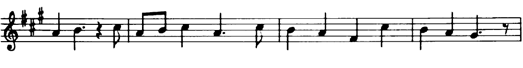

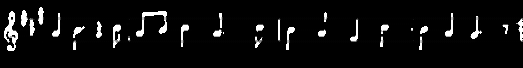

In [138]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow

image_path = "/content/APT_A4_06.png"
src = cv.imread(image_path, cv.IMREAD_COLOR)
if src is None:
    print('Error opening image:', image_path)
    exit()

cv2_imshow(src)

# Convert to grayscale and invert
gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
gray = cv.bitwise_not(gray)

# Apply adaptive thresholding
bw = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                          cv.THRESH_BINARY, 21, -5)

# Remove horizontal lines
horizontal = np.copy(bw)
cols = horizontal.shape[1]
horizontal_size = cols // 6
horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))
horizontal = cv.erode(horizontal, horizontalStructure, iterations=1)
horizontal = cv.dilate(horizontal, horizontalStructure, iterations=10)

# Create mask for inpainting (horizontal lines)
mask = horizontal

# Inpaint to remove horizontal lines
bw_color = cv.cvtColor(bw, cv.COLOR_GRAY2BGR)
inpainted = cv.inpaint(bw_color, mask, inpaintRadius=1, flags=cv.INPAINT_TELEA)
inpainted_gray = cv.cvtColor(inpainted, cv.COLOR_BGR2GRAY)

# Apply median blur to smooth the image
inpainted_gray = cv.medianBlur(inpainted_gray, 3)

cv2_imshow(inpainted_gray)
